In [1]:
# # Task 4: Model Comparison & Selection for Amharic NER
# ## 1. Install Necessary Libraries
!pip install transformers datasets accelerate seqeval matplotlib -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset, Features, Sequence, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

# ## 3. Define Labels and ID-to-Label Mapping

Raw Training examples: 8
Raw Evaluation examples: 3

--- Starting training for: xlm-roberta-base ---


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/tmp/ipython-input-5-114918237.py:243: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,2.119598,0.000000,0.000000,0.000000,0.047619
2,No log,2.090091,0.000000,0.000000,0.000000,0.047619
3,No log,2.075781,0.000000,0.000000,0.000000,0.047619


Evaluation results for xlm-roberta-base: {'eval_loss': 2.119597911834717, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_accuracy': 0.047619047619047616, 'eval_runtime': 1.1815, 'eval_samples_per_second': 2.539, 'eval_steps_per_second': 0.846, 'epoch': 3.0}

--- Starting training for: bert-base-multilingual-cased ---


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/tmp/ipython-input-5-114918237.py:243: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,1.787900,0.000000,0.000000,0.000000,0.333333
2,No log,1.806406,0.000000,0.000000,0.000000,0.333333
3,No log,1.805180,0.000000,0.000000,0.000000,0.333333


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation results for bert-base-multilingual-cased: {'eval_loss': 1.7878996133804321, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 1.1485, 'eval_samples_per_second': 2.612, 'eval_steps_per_second': 0.871, 'epoch': 3.0}

--- Starting training for: distilbert-base-multilingual-cased ---


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/tmp/ipython-input-5-114918237.py:243: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,1.865805,0.000000,0.000000,0.000000,0.333333
2,No log,1.851352,0.000000,0.000000,0.000000,0.333333
3,No log,1.846321,0.000000,0.000000,0.000000,0.333333


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation results for distilbert-base-multilingual-cased: {'eval_loss': 1.8658051490783691, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.8928, 'eval_samples_per_second': 3.36, 'eval_steps_per_second': 1.12, 'epoch': 3.0}

--- Starting training for: Davlan/afro-xlmr-base ---


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/tmp/ipython-input-5-114918237.py:243: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,1.913704,0.100000,0.090909,0.111111,0.190476
2,No log,1.891523,0.105263,0.100000,0.111111,0.190476
3,No log,1.881135,0.105263,0.100000,0.111111,0.190476


Evaluation results for Davlan/afro-xlmr-base: {'eval_loss': 1.8915228843688965, 'eval_f1': 0.10526315789473685, 'eval_precision': 0.1, 'eval_recall': 0.1111111111111111, 'eval_accuracy': 0.19047619047619047, 'eval_runtime': 1.2762, 'eval_samples_per_second': 2.351, 'eval_steps_per_second': 0.784, 'epoch': 3.0}

--- Model Comparison Summary ---
| Model                              |   F1 Score |   Precision |   Recall |   Accuracy |
|:-----------------------------------|-----------:|------------:|---------:|-----------:|
| xlm-roberta-base                   |     0      |         0   |   0      |     0.0476 |
| bert-base-multilingual-cased       |     0      |         0   |   0      |     0.3333 |
| distilbert-base-multilingual-cased |     0      |         0   |   0      |     0.3333 |
| Davlan/afro-xlmr-base              |     0.1053 |         0.1 |   0.1111 |     0.1905 |


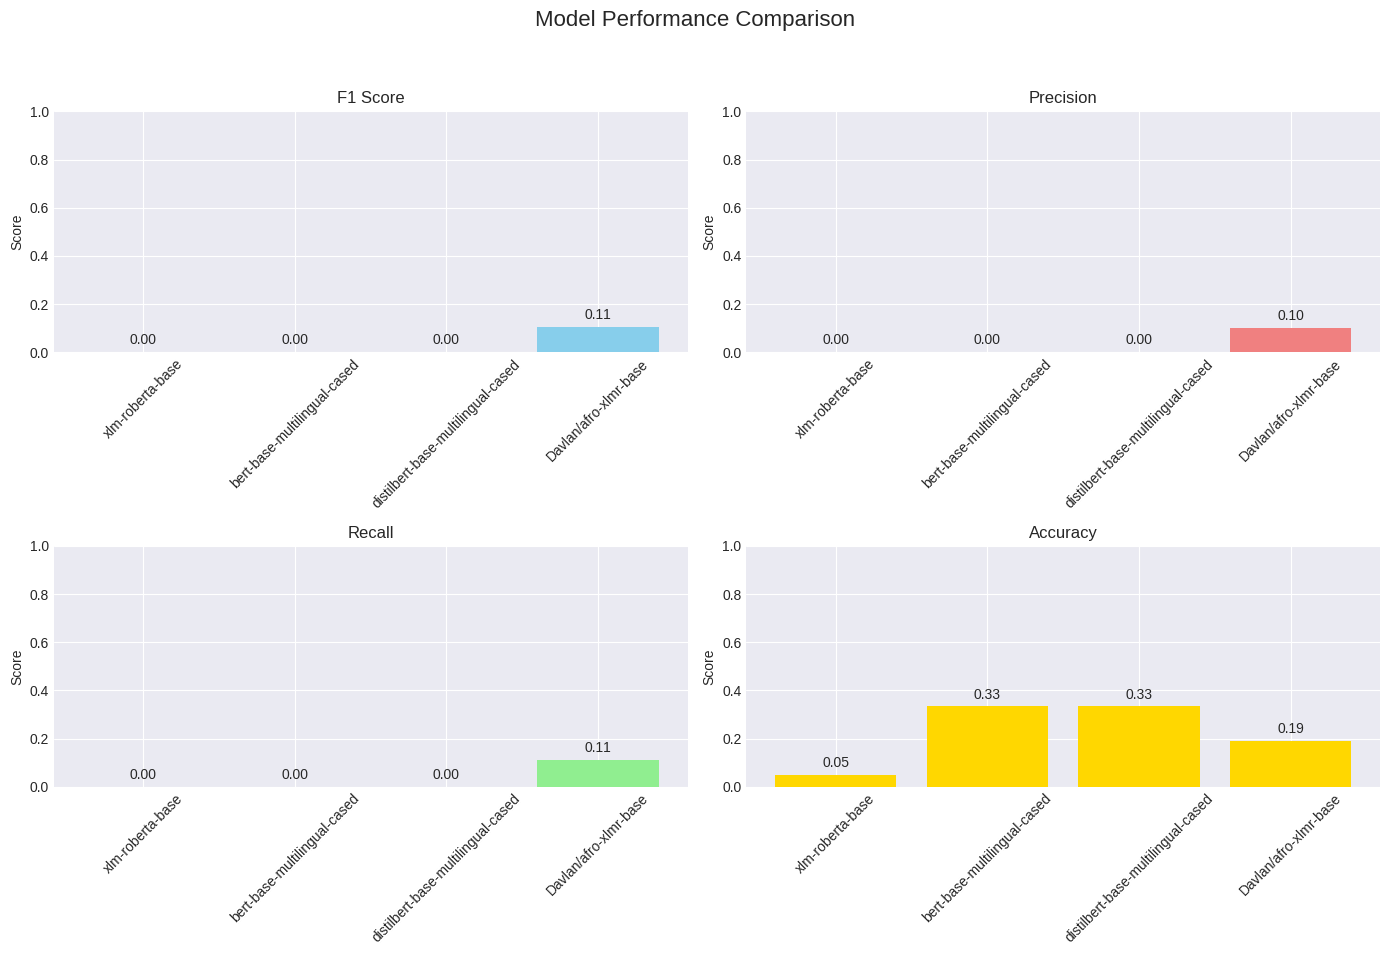


--- Best Performing Model (based on F1 Score) ---
|           | 3                     |
|:----------|:----------------------|
| Model     | Davlan/afro-xlmr-base |
| F1 Score  | 0.10526315789473685   |
| Precision | 0.1                   |
| Recall    | 0.1111111111111111    |
| Accuracy  | 0.19047619047619047   |

Consider this model for further fine-tuning, interpretability analysis (Task 5), and integration into your Vendor Analytics Engine (Task 6). Remember to also consider inference speed and resource requirements for production deployment.


In [5]:
# ## 3. Define Labels and ID-to-Label Mapping
# These labels correspond to the CoNLL format and your entity types.
labels = ["O", "B-Product", "I-Product", "B-LOC", "I-LOC", "B-PRICE", "I-PRICE"]
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}

# ## 4. Load the Labeled Dataset in CoNLL Format
# **IMPORTANT:** Replace this placeholder `conll_data_string` with the actual
# content of your manually labeled CoNLL data from Task 2.
conll_data_string = """
አዲስ	B-LOC
አበባ	I-LOC
ላይ	O
ጥሩ	O
ጥራት	O
ያለው	O
የህፃናት	B-Product
አልጋ	I-Product
በ2500	B-PRICE
ብር	I-PRICE
ብቻ።	O

የሴቶች	B-Product
ቦርሳ	I-Product
በ1200	B-PRICE
ብር	I-PRICE
ቦሌ	B-LOC
አካባቢ	O
ይገኛል።	O

ሳሪስ	B-LOC
ለገበያ	O
የቀረበ	O
ዘመናዊ	B-Product
ቲቪ	I-Product
8000	B-PRICE
ብር።	I-PRICE

ለቤትዎ	O
ውበት	O
የሆኑ	O
መጋረጃዎች	B-Product
በ650	B-PRICE
ብር	I-PRICE
ከፒያሳ።	B-LOC

የወንዶች	B-Product
ሸሚዝ	I-Product
በ950	B-PRICE
ብር	I-PRICE
አዲስ	B-LOC
አበባ።	I-LOC

ጥሩ	O
ስልክ	B-Product
በ1000	B-PRICE
ብር	I-PRICE
ቦሌ	B-LOC
ላይ።	O

ላፕቶፕ	B-Product
በ15000	B-PRICE
ብር	I-PRICE
ሳሪስ	B-LOC
አካባቢ።	O

ለልጆች	O
መጫወቻዎች	B-Product
በ300	B-PRICE
ብር	I-PRICE
ከፒያሳ።	B-LOC

የተለያዩ	O
የቤት	B-Product
እቃዎች	I-Product
7000	B-PRICE
ብር	I-PRICE
አዲስ	B-LOC
አበባ።	I-LOC

ፋሽን	B-Product
ልብሶች	I-Product
800	B-PRICE
ብር	I-PRICE
ቦሌ።	B-LOC

የህፃናት	B-Product
መጫወቻዎች	I-Product
በ450	B-PRICE
ብር	I-PRICE
ሳሪስ።	B-LOC
"""

def parse_conll(conll_string):
    sentences = []
    current_sentence = []
    for line in conll_string.strip().split('\n'):
        if line.strip() == "":
            if current_sentence:
                sentences.append(current_sentence)
            current_sentence = []
        else:
            parts = line.split('\t')
            if len(parts) == 2:
                current_sentence.append(parts)
    if current_sentence:
        sentences.append(current_sentence)
    return sentences

parsed_data = parse_conll(conll_data_string)

processed_data = []
for sentence_data in parsed_data:
    tokens = [item[0] for item in sentence_data]
    ner_tags = []
    for item in sentence_data:
        label_str = item[1]
        if label_str in label2id:
            ner_tags.append(label2id[label_str])
        else:
            ner_tags.append(label2id["O"])
            print(f"Warning: Unknown label '{label_str}' encountered. Assigned 'O'.")

    processed_data.append({"tokens": tokens, "ner_tags": ner_tags})

features = Features({
    'tokens': Sequence(Value('string')),
    'ner_tags': Sequence(ClassLabel(names=labels))
})

dataset = Dataset.from_list(processed_data, features=features)

# ## 5. Tokenize Data and Align Labels
def tokenize_and_align_labels(examples, tokenizer_instance):
    tokenized_inputs = tokenizer_instance(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )
    labels_batch = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels_batch.append(label_ids)
    tokenized_inputs["labels"] = labels_batch
    return tokenized_inputs

# ## 6. Split Dataset
if len(dataset) > 1:
    train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
    raw_train_dataset = train_test_split["train"]
    raw_eval_dataset = train_test_split["test"]
else:
    raw_train_dataset = dataset
    raw_eval_dataset = dataset
    print("Warning: Dataset is too small for meaningful split. Using entire dataset for both train and eval.")

print(f"Raw Training examples: {len(raw_train_dataset)}")
print(f"Raw Evaluation examples: {len(raw_eval_dataset)}")


# ## 7. Function to Train and Evaluate a Model
def compute_metrics(p):
    predictions, labels_ids = p
    predictions = np.argmax(predictions, axis=2)

    true_labels_filtered = []
    true_predictions_filtered = []

    for sentence_labels, sentence_predictions in zip(labels_ids, predictions):
        temp_true_labels = []
        temp_true_predictions = []
        for label_id, pred_id in zip(sentence_labels, sentence_predictions):
            if label_id != -100:
                temp_true_labels.append(label_id)
                temp_true_predictions.append(pred_id)
        true_labels_filtered.append(temp_true_labels)
        true_predictions_filtered.append(temp_true_predictions)

    true_labels_decoded = [[id2label[l_id] for l_id in sublist] for sublist in true_labels_filtered]
    true_predictions_decoded = [[id2label[p_id] for p_id in sublist] for sublist in true_predictions_filtered]

    # Handle cases where true_labels_decoded or true_predictions_decoded might be empty
    if not any(true_labels_decoded) or not any(true_predictions_decoded):
        # If no true labels or predictions after filtering, return zeros for metrics
        return {"f1": 0.0, "precision": 0.0, "recall": 0.0, "accuracy": 0.0}

    # Flatten lists for token-level accuracy calculation
    flat_true_labels = [label for sublist in true_labels_decoded for label in sublist]
    flat_true_predictions = [pred for sublist in true_predictions_decoded for pred in sublist]


    return {
        "f1": f1_score(true_labels_decoded, true_predictions_decoded),
        "precision": precision_score(true_labels_decoded, true_predictions_decoded),
        "recall": recall_score(true_labels_decoded, true_predictions_decoded),
        "accuracy": accuracy_score(flat_true_labels, flat_true_predictions) if flat_true_labels else 0.0
    }


def train_and_evaluate_model(model_checkpoint, train_ds, eval_ds, labels_list, id2label_map, label2id_map):
    print(f"\n--- Starting training for: {model_checkpoint} ---")

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    model = AutoModelForTokenClassification.from_pretrained(
        model_checkpoint,
        num_labels=len(labels_list),
        id2label=id2label_map,
        label2id=label2id_map
    )

    # Tokenize datasets using the current tokenizer
    tokenized_train_ds = train_ds.map(lambda x: tokenize_and_align_labels(x, tokenizer), batched=True)
    tokenized_eval_ds = eval_ds.map(lambda x: tokenize_and_align_labels(x, tokenizer), batched=True)

    data_collator = DataCollatorForTokenClassification(tokenizer)

    training_args = TrainingArguments(
        output_dir=f"./results_{model_checkpoint.replace('/', '-')}",
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none" # Disable logging to external services for cleaner output
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_eval_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print(f"Evaluation results for {model_checkpoint}: {eval_results}")

    return eval_results

# ## 8. Model Checkpoints to Compare
# You can add or remove models here.
model_checkpoints = [
    "xlm-roberta-base",
    "bert-base-multilingual-cased",
    "distilbert-base-multilingual-cased",
    "Davlan/afro-xlmr-base" # A model specifically tuned for African languages
]

comparison_results = []

for checkpoint in model_checkpoints:
    metrics = train_and_evaluate_model(
        checkpoint,
        raw_train_dataset,
        raw_eval_dataset,
        labels,
        id2label,
        label2id
    )
    comparison_results.append({
        "Model": checkpoint,
        "F1 Score": metrics.get("eval_f1", 0.0),
        "Precision": metrics.get("eval_precision", 0.0),
        "Recall": metrics.get("eval_recall", 0.0),
        "Accuracy": metrics.get("eval_accuracy", 0.0)
    })

# ## 9. Compare Models: Summary Table
results_df = pd.DataFrame(comparison_results)
print("\n--- Model Comparison Summary ---")
print(results_df.round(4).to_markdown(index=False))


# ## 10. Compare Models: Visualizations (Plots)

# Set a style for better visualization
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# F1 Score
axes[0, 0].bar(results_df['Model'], results_df['F1 Score'], color='skyblue')
axes[0, 0].set_title('F1 Score')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(results_df['F1 Score']):
    axes[0, 0].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# Precision
axes[0, 1].bar(results_df['Model'], results_df['Precision'], color='lightcoral')
axes[0, 1].set_title('Precision')
axes[0, 1].set_ylim(0, 1)
for i, v in enumerate(results_df['Precision']):
    axes[0, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# Recall
axes[1, 0].bar(results_df['Model'], results_df['Recall'], color='lightgreen')
axes[1, 0].set_title('Recall')
axes[1, 0].set_ylim(0, 1)
for i, v in enumerate(results_df['Recall']):
    axes[1, 0].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# Accuracy
axes[1, 1].bar(results_df['Model'], results_df['Accuracy'], color='gold')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_ylim(0, 1)
for i, v in enumerate(results_df['Accuracy']):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# Rotate x-axis labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45, labelbottom=True)
    ax.set_ylabel('Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ## 11. Select the Best-Performing Model for Production

# Based on the summary table and plots, you would select the model that best
# meets your criteria.
#
# **General Selection Criteria:**
# 1.  **Highest F1-Score:** This is often the most critical metric for NER as it balances false positives and false negatives.
# 2.  **Precision & Recall Balance:** Depending on your application, you might prioritize one over the other (e.g., high precision if false positives are very costly, high recall if missing entities is very costly).
# 3.  **Accuracy:** While important, be aware that high accuracy can be misleading in imbalanced datasets (e.g., if most tokens are "O").
# 4.  **Speed (Inference Time):** Smaller models (like DistilBERT) are faster for real-time inference, which is crucial for production.
# 5.  **Robustness:** How well does the model handle variations in text, misspellings, or unseen patterns? This is harder to quantify solely from metrics and might require qualitative analysis of challenging examples (as in Task 5).
#
# **Example Selection Logic (Programmatic):**
best_model_f1 = results_df.loc[results_df['F1 Score'].idxmax()]
print(f"\n--- Best Performing Model (based on F1 Score) ---")
print(best_model_f1.to_markdown(index=True))

print("\nConsider this model for further fine-tuning, interpretability analysis (Task 5), and integration into your Vendor Analytics Engine (Task 6). Remember to also consider inference speed and resource requirements for production deployment.")